# Two-point Boundary Value Problem
## Fixed Final time with Cubic Dynamics 

**Goal:**  (Notes 6-5)
$$\min J = \frac{1}{2} \int_{t_0}^{t_f} \left[v^2(t)+u^2(t)\right] dt$$
with $t_f$ fixed, $x_f$ free, and dynamics
$
\dot v = \alpha v^3 + u
$

- Optimal solution must satisfy $u(t) = - p(t)$ and that
\begin{eqnarray}
\dot v(t) &=& \alpha v(t)^3 - p(t)\\
\dot p(t) &=& -v(t) - 3\alpha v(t)^2 p(t)
\end{eqnarray}
where $v(t_0)$ given and since the end point is free, then we need $p(t_f)=0$

- Will compare the optimal with an approximate "model inversion" type controller
$$
u_a(t) = -\beta x_a(t) - \alpha x^3_a(t)
$$
which cancels the nonlinearity (i.e. like an inversion) and results in closed-loop dynamics $\dot x_a(t) = -\beta x_a(t)$.


In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

# check if ipopt is installed. If not, install.
if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

Running Python: 3.8.12


In [2]:
def my_solve(tf = 8, x0 = 1): # create a model object
    alpha = -0.5 # system dynamics
    beta = 0.9 # approx control gain
    m = ConcreteModel()

    # define the independent variable
    m.t = ContinuousSet(bounds=(0,tf))
    # define control inputs
    m.u = Var(m.t)

    # define the dependent variables
    m.x1 = Var(m.t)  # x1 = v
    m.p = Var(m.t)

    # define derivatives
    m.x1_dot = DerivativeVar(m.x1, wrt=m.t)
    m.p_dot = DerivativeVar(m.p, wrt=m.t)

    m.ode_x1 = Constraint(m.t, rule=lambda m, t: m.x1_dot[t] == alpha*m.x1[t]**3+m.u[t])
    m.ode_p = Constraint(m.t, rule=lambda m, t: m.p_dot[t] == -m.x1[t]-3*alpha*m.x1[t]**2*m.p[t])

    # initial conditions
    m.pc = ConstraintList()
    m.pc.add(m.x1[0]==x0)
    m.pc.add(m.p[tf]==0)

    def _con(m, t):
        return m.u[t]== -m.p[t]
    m.con = Constraint(m.t, rule=_con)

    # compute cost so that we can evaluate it - not used in optimization
    m.J = Var(m.t)
    m.J_dot = DerivativeVar(m.J)
    m.ode_J = Constraint(m.t, rule=lambda m, t: m.J_dot[t] == (m.x1[t]**2 + m.u[t]**2)/2)
    m.pc.add(m.J[0]==0)

    m.xapprox = Var(m.t)  # x1 = v
    m.uapprox = Var(m.t)  # x1 = v
    m.xapprox_dot = DerivativeVar(m.xapprox, wrt=m.t)
    m.ode_xapprox = Constraint(m.t, rule=lambda m, t: m.xapprox_dot[t] == alpha*m.xapprox[t]**3+m.uapprox[t])
    m.Japprox = Var(m.t)
    m.Japprox_dot = DerivativeVar(m.Japprox)
    m.ode_Japprox = Constraint(m.t, rule=lambda m, t: m.Japprox_dot[t] == (m.xapprox[t]**2 + m.uapprox[t]**2)/2)
    m.pc.add(m.xapprox[0]==x0)
    m.pc.add(m.Japprox[0]==0)

    def _con2(m, t):
          return m.uapprox[t] == -beta*m.xapprox[t] - alpha*m.xapprox[t]**3
    m.con2 = Constraint(m.t, rule=_con2)

    # transform and solve
    TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=1000)
    solver = SolverFactory('ipopt')
    solver.options['max_iter']= 10000 #number of iterations you wish
    solver.solve(m)#.write()
    return m

**Note:** For $x(0) = 1$ the approximate control is close to optimal, but the cubic input term greatly changes the amount of control effort for other values of $x(0)$.


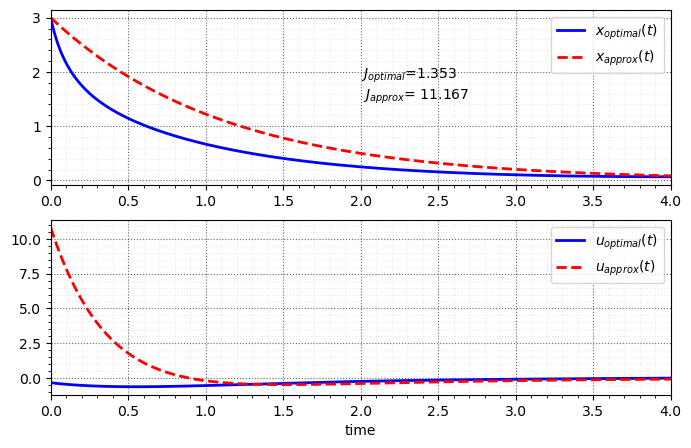

In [3]:
tf = 4 # Final time
x0 = 3  # Initial state
m = my_solve(tf,x0)

# access the results
tt = np.array([t for t in m.t])
x1 = np.array([m.x1[t]() for t in m.t])
u = np.array([m.u[t]() for t in m.t])
p = np.array([m.p[t]() for t in m.t])
J = np.array([m.J[t]() for t in m.t])[-1]

xapprox = np.array([m.xapprox[t]() for t in m.t])
uapprox = np.array([m.uapprox[t]() for t in m.t])
Ja = np.array([m.Japprox[t]() for t in m.t])[-1]

plt.figure(1,figsize=(8,5))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
nicegrid(ax1)
ax1.plot(tt, x1, 'b-',label=r'$x_{optimal}(t)$')
ax1.plot(tt, xapprox, 'r--',label=r'$x_{approx}(t)$')
ax2.plot(tt, u, 'b-',label=r'$u_{optimal}(t)$')
ax2.plot(tt, uapprox, 'r--',label=r'$u_{approx}(t)$')
ax2.set_xlabel('time')
ax1.set_xlim([0, tf])
ax2.set_xlim([0, tf])
ax1.text(tf/2,x0/2,'$J_{optimal}$='+str(round(J,3))+'\n $J_{approx}$= '+str(round(Ja,3)))
ax1.legend(loc='best')
ax2.legend(loc='best')
nicegrid(ax2)

In [4]:
print("Choose options:")
def func(Final_time = 12, Initial_x = 1):
    tf = Final_time 
    x0 = Initial_x
    m = my_solve(tf,x0)

    tt = np.array([t for t in m.t])
    x1 = np.array([m.x1[t]() for t in m.t])
    u = np.array([m.u[t]() for t in m.t])
    p = np.array([m.p[t]() for t in m.t])
    J = np.array([m.J[t]() for t in m.t])[-1]

    xapprox = np.array([m.xapprox[t]() for t in m.t])
    uapprox = np.array([m.uapprox[t]() for t in m.t])
    Ja = np.array([m.Japprox[t]() for t in m.t])[-1]

    plt.figure(2,figsize=(8,5))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    nicegrid(ax1)
    ax1.plot(tt, x1, 'b-',label=r'$x_{optimal}(t)$')
    ax1.plot(tt, xapprox, 'r--',label=r'$x_{approx}(t)$')
    ax2.plot(tt, u, 'b-',label=r'$u_{optimal}(t)$')
    ax2.plot(tt, uapprox, 'r--',label=r'$u_{approx}(t)$')
    ax2.set_xlabel('time')
    ax1.set_xlim([0, tf])
    ax2.set_xlim([0, tf])
    ax1.text(tf/2,x0/2,'$J_{optimal}$='+str(round(J,3))+'\n $J_{approx}$= '+str(round(Ja,3)))
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    nicegrid(ax2)

y = interactive(func,{'manual': False},Final_time=(1,20,1),Initial_x=(0.1,5,.25))
y

Choose options:


interactive(children=(IntSlider(value=12, description='Final_time', max=20, min=1), FloatSlider(value=1.0, des…